# How to use the <code>authdetect</code> model? A practical tutorial

Author: Michal Mochtak

Date: Ocotber 10, 2024

## Introductory remarks ⛳

This is an interactive Jupyter notebook that presents a step-by-step tutorial on how to use the **<code>authdetect</code>** model with your own data. The overall structure of the notebook is organized around two elements: 1) sentence trigrams extraction and 2) sentence trigrams annotation.

If you use this tutorial, please cite the paper:


> Mochtak, Michal (forthcoming): Chasing the Authoritarian Specter: Detecting Authoritarian Discourse with Large Language Models. European Journal of Political Research.



## Prerequisities ⚡
Google Colab is an interactive development environment with access to computational resources that are easy to utilize free of charge (read more about it here: https://colab.research.google.com/).

To use the <code>authdetect</code> model, you first need to connect to an interactive session with access to a graphical processing unit. To do this, click "Runtime" in the top toolbar and select "Change runtime type":
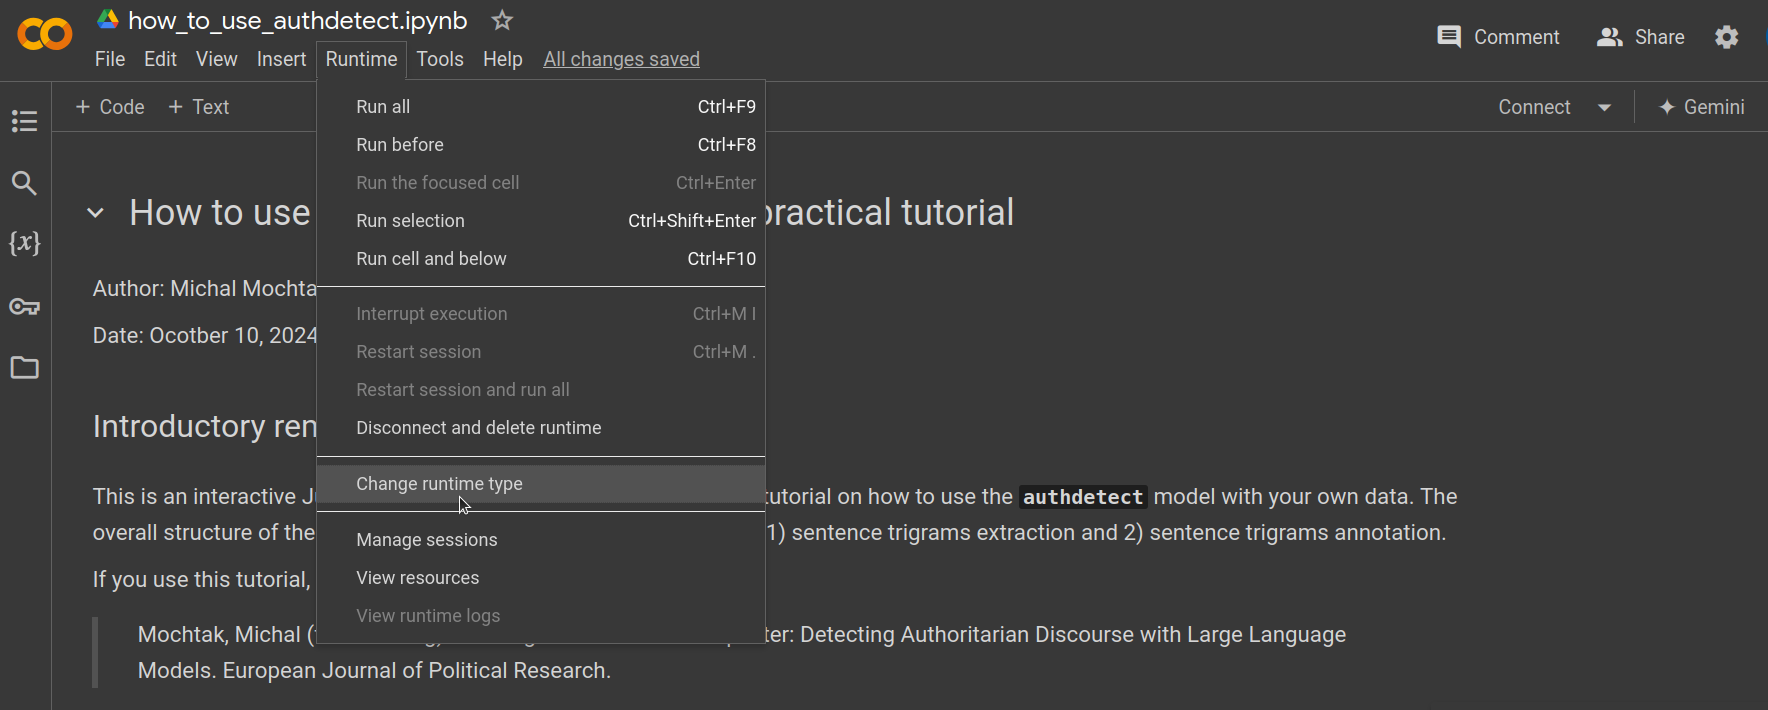

<br>
<br>
After a pop-up appears, select any available GPU accelerator and save your selection:

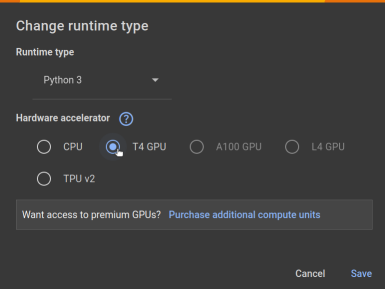

Finally, in the top right corner, click "Connect." After a moment, a green check mark (✔) will appear, indicating that your virtual session has been successfully set up:

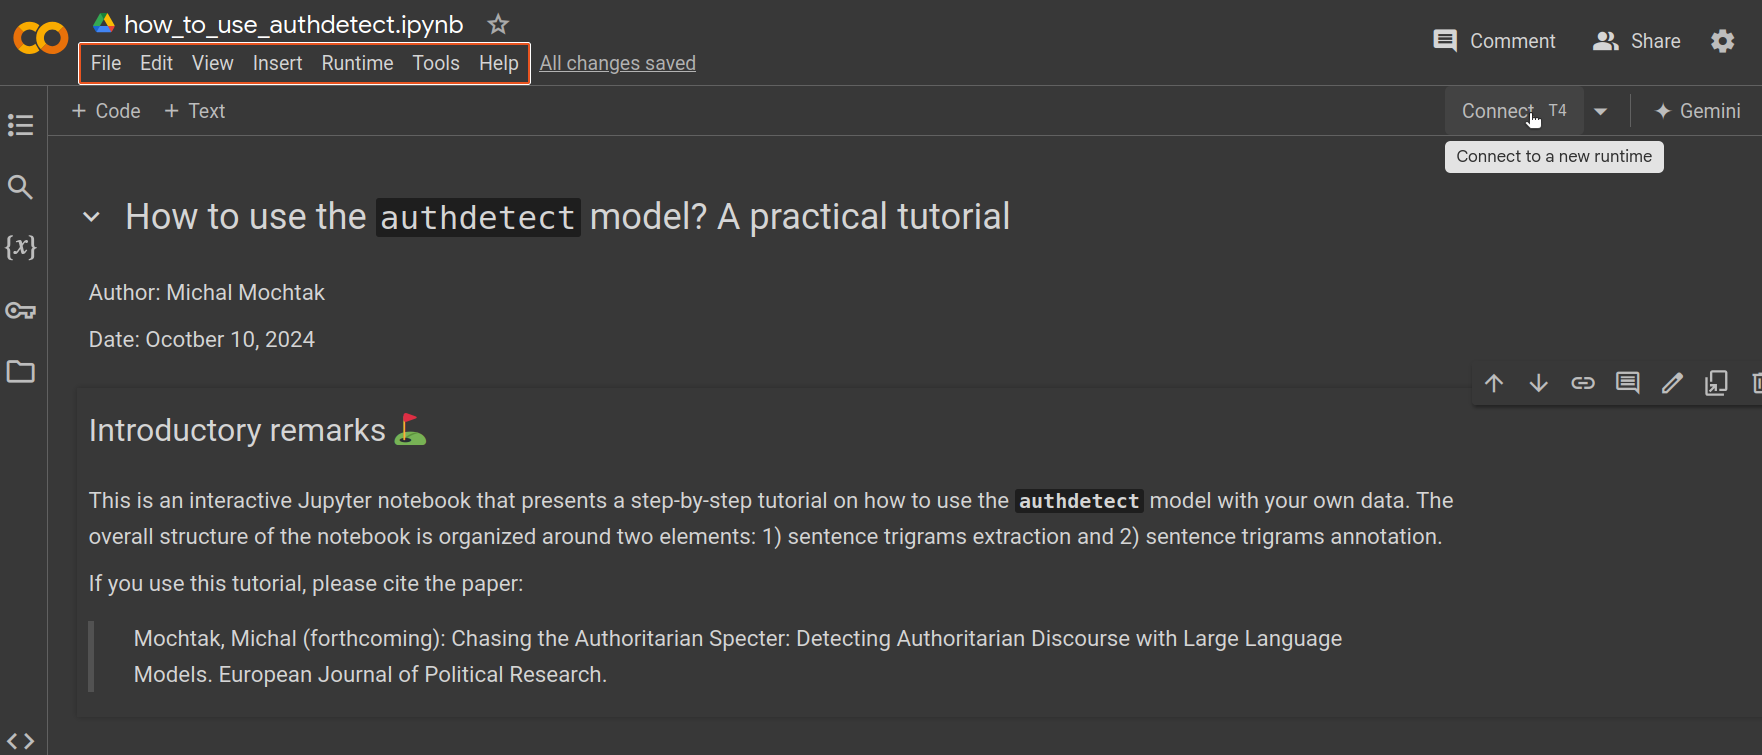

## Loading data for processing 💾
This notebook is designed for a simple use case that expects users to prepare their data outside the Google Colab environment as a plain .csv file and then upload it for further processing. The repository for this paper contains a sample file that you can use as a guide for formatting your own data. The file contains 193 speeches in English from the 79 session of the UN General Assambley (2024). The file contaisn multiple columns but the pipeline needs only two of them: "doc_id" as a document identifier and "speech" for the actual speeches (the pipeline does not require anything else).

**Disclaimer**: Although the speeches come from the UN General Assembly, they were not part of the training process (the last included session used during the training was the 77th meeting held in 2022). The 79th session, held in September 2024, is the most recent session and was collected solely for the purpose of this tutorial. The benefit of working with UN data is that it is representative, capturing speeches from leaders of 193 countries.

To use the file (or any other file you prepare), upload it to your interactive session by clicking the folder icon on the left and dragging and dropping your file into the area under the "sample_data" folder. The file will be uploaded to your interactive session and will be available for processing. It is important to note that the file exists only in this interactive session and will be deleted when you close it. This applies to any file you create in your session (e.g., the processed data).

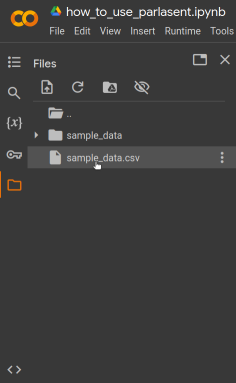



## Processing the data 🎆

The processing pipeline can be divided into two steps: 1) sentence trigrams extraction and 2) sentence trigrams annotation. From this point on, the notebook will also include code cells that can be executed by clicking the small "play" icon next to them (hover over the cell to make it visible).

### Loading the necessary libraries 💻
To process the input data, we need to install and load a few packages we will use.

In [ ]:
# Install missing packages in your session; this needs to be done each time you
# open the notebook, as the session is interactive. It takes a while.
!pip install simpletransformers
!pip install trankit==1.1.1

In [ ]:
# Load the necessary packages.
import simpletransformers.classification as cl
import trankit
import pandas as pd

### Step 1: Sentence trigrams extraction ⛏
Now that all the necessary packages are loaded and ready to use, we can proceed with the first step—sentence trigram extraction (the actual input for the <code>authdetect</code> model).

In [ ]:
# Load the dataset you want to process. This tutorial uses a plain .csv file for simplicity.
df = pd.read_csv("sample_data.csv")

In [ ]:
# Load the trankit pipeline with the English language model
p = trankit.Pipeline(lang='english', embedding='xlm-roberta-base', gpu=True, cache_dir='./cache')

In [ ]:
# Check the dataset to be sure it was read in correctly.
print(df)

     doc_id                                             speech  \
0         1  The Assembly will hear an address by His Excel...   
1         2  The Assembly will hear an address by His Excel...   
2         3  The Assembly will hear an address by His Royal...   
3         4  The Assembly will hear an address by His Excel...   
4         5  The Assembly will hear an address by His Excel...   
..      ...                                                ...   
188     189  I now give the floor to His Excellency Ludvig ...   
189     190  I now give the floor to His Excellency Bakary ...   
190     191  I now give the floor to His Excellency, Peter ...   
191     192  I now give the floor to His Excellency Bassem ...   
192     193  And I now give the floor to His Excellency She...   

                                                  link               country  \
0                 https://gadebate.un.org/en/79/angola                Angola   
1              https://gadebate.un.org/en/79/ar

In [ ]:
# Split texts into sentences. We use a simple loop as the model processes inputs sequentially.
sentences = []
for n in range(0, len(df["speech"])):
  one_text = pd.DataFrame.from_dict(p.ssplit(df["speech"][n]))
  one_text["doc_id"] = df["doc_id"][n]
  one_text = one_text.drop(["text", "lang"], axis = 1)
  sentences.append((one_text))

# Concatenate the list and reset the index.
sentences = pd.concat(sentences)
sentences.reset_index(drop=True, inplace=True)

# Extract data from JSON format and patch everything together.
sentences_final = pd.concat([sentences.drop(['sentences'], axis=1), pd.json_normalize(sentences['sentences'].tolist())], axis=1)

In [ ]:
# Check the result of sentence extraction. It is a data frame with the following columns:
# - doc_id: Refers to the original document.
# - id: Refers to the sentence ID within the processed input (e.g., speech).
# - text: Contains the extracted grammatical units (i.e., the sentences).
# - dspan: Contains indexes for the beginning and end of each sentence in the processed string.

print(sentences_final)

In [ ]:
# Helper function for creating sentence trigrams. Sentence trigram is the main input for the authdetect model.
def create_ngram(text):
    no_steps = len(text) - 2
    indexes = [list(range(x, x + 3)) for x in range(no_steps)]
    ngrams = [' '.join(text[i] for i in index) for index in indexes]
    return ngrams

In [ ]:
# Wrangle extracted sentences into sentence trigrams
all_data = []

u_docs = sentences_final['doc_id'].unique()

for n in range(len(u_docs)):
    one_doc = sentences_final[sentences_final['doc_id'] == u_docs[n]]
    text = one_doc['text'].tolist()

    if len(text) < 3:
      sentence_trigram = [' '.join(text)]
    else:
      # create trigrams
      sentence_trigram = create_ngram(text)

    # extract the first row excluding the 3th column
    doc_id = one_doc['doc_id'].iloc[0]

    # create a DataFrame with sentence trigrams
    sentence_df = pd.DataFrame({'sent_trigram': sentence_trigram})

    # add an 'id' and 'doc_id' column as standard refeferences
    sentence_df['id'] = range(1, len(sentence_trigram) + 1)
    sentence_df['doc_id'] = int(doc_id)

    all_data.append(sentence_df)

# concatenate all the new data into a final DataFrame
final = pd.concat(all_data, ignore_index=True)

### Step 2: Detecting authoritarian discourse 🌡
With the extracted sentence trigrams, we can proceed to the second step: detecting authoritarian discourse.

In [ ]:
# Load the authdetect model from the Huggingface Hub.
model = cl.ClassificationModel("roberta", "mmochtak/authdetect")

In [ ]:
# Annotate the prepared trigrams with the authdetect model.
prediction = model.predict(to_predict = final["sent_trigram"].tolist())

anno_df = final.assign(predict = prediction[1])

In [ ]:
# Check the result. The `anno_df` data frame now contains an additional column
# called "predict" with the predictions made by the model. Since the classification model
# predicts the label (score) on a continuous scale, similar to a regression model,
# it can produce scores above or below the scale used for training (polyarchy index;
# 0-1 where 0 means almost exclusively associated with authoritarian discourse and
# 1 means almost exclusively associated with democratic discourse). Higher means more democratic,
# lower means more authoritarian discourse.
# It is worth mentioning that annotating 193 speeches containing 19,852 sentence trigrams
# took approximately 50 seconds (on a T4 GPU).
print(anno_df)

In [ ]:
# Save the annotated data as a .csv file. The new file will be located in the same
# directory as the input file you uploaded at the beginning. If it does not
# appear automatically, click the refresh button (the circled arrow) to reload
# the folder's content. To download the file, right-click on it and select "Download"
# to save it to your local machine.
anno_df.to_csv('output_sent_trigram.csv', index=False)

In [ ]:
# In order to aggregate the scores of individual sentence trigrams back to the speech level,
# various strategies can be applied. The two most intuitive are the simple mean and the ratio of
# authoritarian trigrams.
# 'auth' is calculated as one minus the simple average of all trigrams per document.
# This gives a more intuitive 0-1 scale, where a higher score is more associated with authoritarian discourse.
#'authesent' captures the ratio of sentences that are associated with authoritarian discourse more than
# with democratic discourse (i.e., the assigned polyarchy index is lower than 0.5).
anno_df_speech = anno_df.groupby('doc_id').agg(
    auth=('predict', lambda x: 1 - x.mean()),
    authsent=('predict', lambda x: (x < 0.5).mean())
).reset_index()

In [ ]:
# Finally, concatenate the speech level scores with the original dataset (the one with the raw text)
# and save it as a .csv file.
df_final = pd.concat([df, anno_df_speech[['auth', 'authsent']]], axis=1)
df_final.to_csv('output_speeches_auth.csv', index=False)

## Closing remarks 👋
The tutorial has guided you through the entire annotation pipeline. It demonstrated how easy it is to set up and execute the <code>authdetect</code> model on your own data. The result is a plain data frame with annotated sentence trigrams or whole speeches that can be further processed or aggregated for specific research purposes (e.g., speakers, time periods, or groups).